In [14]:
import os
import mlflow
import optuna
import joblib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from copy import deepcopy
from pathlib import Path
from dotenv import load_dotenv
import sys

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.outliers import ArbitraryOutlierCapper
from feature_engine.timeseries.forecasting import WindowFeatures
import matplotlib
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 8.5

# **3W Data**

The 3W dataset is a collection of sensor measurements gathered from real-world offshore oil well operations, supplemented by software-simulated data and hand-crafted synthetic data. It includes eight types of abnormal events.

The data is organized into separate folders for each type of event, with each individual data acquisition session saved as a comma-separated value (CSV) file. These sessions capture sensor measurements recorded over time. The files are named according to their data source (real, simulated, or synthetic), followed by sequential numbering. For real events, a timestamp is also included in the file name.

Each file represents an instance of a type of abnormal event and typically contains the entire signal, starting from normal operation, progressing through the transient period, and concluding with the steady-state anomaly. The following table provides a summary of the number of instances available for each abnormal event and its source:

<center><img src="../figures/instances_3wdataset.png" width="600" height="400"></center>


The following table shows the number of observations (or data points) captured during real events in the dataset. Each event is categorized into three stages: Normal, Transient, and Steady-state.

- **Normal**: Period when the system operates without any anomalies.
- **Transient**:  Phase where the anomaly begins to develop.
- **Steady-state**: Phase where the anomaly has fully manifested and stabilized.


<center><img src="../figures/nobservations_real_3wdataset.png" width="600" height="400"></center>

## **Observations**

1) From tables 1 and 2, we can see that the flow instability event is only represented by real instances and is available just for steady-state signal. In flow instability, the boundaries between normal and abnormal conditions are not clearly defined because the system slowly moves from a stable state to an unstable one. These small changes make it difficult to determine exactly when the anomaly starts.

2) From tables 1 and 2, we can see that the Severe Slugging event has data from both simulated and real sources, but for real data, there is only for the steady-state. This is because Severe Slugging typically has a sudden onset, meaning the transition from normal operation to slugging occurs abruptly without a gradual or easily detectable progression. As a result, the dataset captures only the fully developed, steady-state phase of the fault, where the severe slugging has stabilized and is most prominent. The rapid nature of this event makes it difficult to capture any transient period before the fault fully manifests.

3) The dataset's class imbalance, where certain events have far fewer instances or observations. This imbalance poses challenges for machine learning, as it can lead to biased models. Therefore, model evaluation requires special consideration, particularly in selecting appropriate metrics like precision, recall, or F1-score to accurately assess performance in the imbalanced data.




## **Eight  types of abnormal events (Classes):** 

0) **Normal**:
Naturally flowing wells are those in which the formation pressure is sufficient to produce oil commercially without requiring a pump. Most reservoirs at the initial stage of development have enough pressure for a natural flow and thus require less equipment and automation for control and successful oil and gas production.

1) **Abrupt increase in BSW (Basic Sediment and Water)**:
Suspended water, sediments and other impurities in the production measured as a percentage of the production stream.The lifecycle of each well contains periods of increasing levels of BSW. However, an unexpected rise indicates a developing production issue, which needs to be remedied quickly.

2) **Spurious closure of the DHSV (Downhole Safety Valve)**:
The valve isolates wellbore fluids in a catastrophic failure of surface equipment. If the valve fails spuriously without any surface signs, it needs to be reopened; hence, an automatic event identification is essential.

3) **Severe slugging**:
An event in which large gas bubbles follow a sequence of liquid slugs. It is a cyclical phenomenon that can lead to wellhead and pipeline damage. Hence, it is considered a critical abnormality.

4) **Flow instability**:
Pressure changes within acceptable thresholds, with differences due to slugging, representing the absence of cyclicity. This event can transform into slugging and then a severe variant, which requires imminent actions. 

5) **Rapid productivity decline**: 
Flow loss due to changes in reservoir static pressure, alternating BSW percentage, production viscosity, changes in production line diameter, etc.

6) **Sudden restriction in the production choke (PCK)**: 
Quick restriction in the production choke (PCK) – a term Petrobras uses to indicate issues with a PCK valve installed at the beginning of the production line. Short restrictions might be observed when operated manually due to operational problems that need to be identified and reversed.

7) **Scaling in the PCK**:
A mineral deposit, which can create a significant restriction or even a plug in the production tubing. Thus, monitoring production choke helps recognise the event and take appropriate actions, such as scale inhibitor injections.

8) **Hydrate formation in the production line**:
Compounds of complex ions formed by water and other substances at reduced temperatures and high pressure, which might lead to plugging of the pipelines. It is one of the most significant issues in oil and gas production, and it can stop flow for an extended period; hence, it needs to be recognised immediately.




## **Features predicting Severe Slugging in binary classification:**

A possible setup of such system includes pressure measurement with the Pressure  Downhole Gauge (PDG), located inside the well; temperature and pressure with the  Temperature and Pressure Transducer (TPT), located inside the Subsea Christmas Tree  (XTREE); pressure and temperature at the gas lift choke (GLCK); and pressure and  temperature in the production choke (PCK), located on the platform.

<center><img src="../figures/offshore.png.png" width="600" height="500"></center>

- **P-PDG**: Temperature at the PDG (Permanent Downhole Gauge) [ºC];

- **P-TPT**: Pressure at the TPT (temperature and pressure transducer) [Pa];

- **T-TPT**: Temperature at the TPT (temperature and pressure transducer) [ºC];

- **P-MON-CKP**: Upstream pressure of the PCK (production choke) [Pa];

- **T-JUS-CKP**: Downstream temperature of the PCK (production choke) [ºC];

- **P-JUS-CKGL**: Downstream pressure of the GLCK (gas lift choke) [Pa];

- **T-JUS-CKGL**: Downstream temperature of the GLCK (gas lift choke) [ºC];

- **QGL**: Gas lift flow rate [m3/s];

- **class**: Label of the observation;

- **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

### **Boolean columns to check if the value is missing**

- P-PDG__is_missing
- P-TPT__is_missing
- T-TPT__is_missing
- P-MON-CKP__is_missing
- T-JUS-CKP__is_missing       
- P-JUS-CKGL__is_missing
- T-JUS-CKGL__is_missing
- QGL__is_missing

# **Binary Classification for Severe Slugging**

# Load metadata

In [25]:
def process_metadata(dir_path, folder_classes=['3', '0'], file_format='.csv'):
    
    addresses, instances, events, y = [], [], [], []
    for root, _, files in os.walk(dir_path):
        
        # last name in the folder path is the class
        event = os.path.basename(root)
        if event in folder_classes:
            for file in files:
                if file.endswith(file_format):
                    address = os.path.join(root, file)
                    instance = file.split('.')[0]
                    
                    if len(folder_classes) == 2:
                        positive_class = folder_classes[0]
                        y_ = 1 if event == positive_class else 0
                    else:
                        y_ = event
                    addresses.append(address)
                    instances.append(instance)
                    events.append(event)
                    y.append(y_)
                    
    sorted_data = sorted(zip(addresses, instances, events, y), key=lambda item: item[0])
    addresses, instances, events, y = map(list, zip(*sorted_data))
    return addresses, instances, events, y

dir_path = os.path.expanduser('~/github/vfm_3wdataset/data_slug')
addresses, instances, events, y = process_metadata(dir_path, ['3', '0'])
                    

In [26]:
addresses_train, addresses_test, instances_train, \
instances_test, events_train, events_test,\
y_train, y_test = train_test_split(
    addresses, instances, events, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

data_instances_info = np.column_stack(
    [
        np.concatenate([addresses_train, addresses_test], axis=0),
        np.concatenate([instances_train, instances_test], axis=0),
        np.concatenate([events_train, events_test], axis=0),
        np.concatenate([y_train, y_test], axis=0),
        np.concatenate([['Train']*len(y_train), ['Test']*len(y_test)])
    ]
)

df_metadata = pd.DataFrame(data=data_instances_info, columns=['Address', 'Instance', 'Event', 'Class', 'Set'])
df_metadata['id'] = np.arange(df_metadata.shape[0])
df_metadata.head()

,Address,Instance,Event,Class,Set,id
0,/home/marcos/github/vfm_3wdataset/data_slug/3/...,SIMULATED_00067,3,1,Train,0
1,/home/marcos/github/vfm_3wdataset/data_slug/3/...,SIMULATED_00041,3,1,Train,1
2,/home/marcos/github/vfm_3wdataset/data_slug/0/...,WELL-00005_20170817170000,0,0,Train,2
3,/home/marcos/github/vfm_3wdataset/data_slug/3/...,SIMULATED_00039,3,1,Train,3
4,/home/marcos/github/vfm_3wdataset/data_slug/0/...,WELL-00005_20170402230127,0,0,Train,4


In [27]:
ids_train = df_metadata[df_metadata.Set == 'Train'].id.values
ids_test = df_metadata[df_metadata.Set == 'Test'].id.values

mean_y_train = np.mean(np.array(y_train).astype(float))
print(mean_y_train)
mean_y_test = np.mean(np.array(y_test).astype(float))
print(mean_y_test)

0.1512455516014235
0.14893617021276595


# Preprocessing data

In [29]:
def preprocess(df, periods_undersample: int or str or None = None, positive_event = None):

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.index = df['timestamp']
    df = df.drop(columns=['timestamp'])
                

    df = df.ffill().bfill()

    if positive_event is not None:
        df['class'] = df['class'].apply(lambda x: positive_event in str(x)).astype(int)

    for col in df.columns:
        if col != 'class': 
            df[f"{col}__is_missing"] = 1 if df.isna().sum()[col] == df.shape[0] else 0

    df = df.fillna(0)

    if type(periods_undersample) in [int, str]:
        if type(periods_undersample) == int:
            periods_undersample = f'{periods_undersample}s'  
            
        df = df.resample(periods_undersample).last() 
    
    return df
    

def preprocess_all(addresses, ids, periods_undersample, positive_event):
    df_list = []

    for address, id_ in zip(addresses, ids):
        df = preprocess(pd.read_csv(address), periods_undersample, positive_event)
        
        df['id'] = id_
        df_list.append(df)
    
    df = pd.concat(df_list, axis=0)
    return df

df_train = preprocess_all( addresses=addresses_train, ids=ids_train, periods_undersample=60, positive_event='3')
display(df_train.head())

df_test = preprocess_all( addresses=addresses_test, ids=ids_test, periods_undersample=60, positive_event='3')
display(df_test.head())

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class,P-PDG__is_missing,P-TPT__is_missing,T-TPT__is_missing,P-MON-CKP__is_missing,T-JUS-CKP__is_missing,P-JUS-CKGL__is_missing,T-JUS-CKGL__is_missing,QGL__is_missing,id
timestamp,,,,,,,,,,,,,,,,,,
2018-04-10 23:49:00,24048050.0,15656440.0,119.3033,10062140.0,90.57189,0.0,0.0,0.0,1,0,0,0,0,0,1,1,1,0
2018-04-10 23:50:00,24108100.0,15736100.0,119.2536,10066590.0,90.86570,0.0,0.0,0.0,1,0,0,0,0,0,1,1,1,0
2018-04-10 23:51:00,24147830.0,15796550.0,119.2263,10070230.0,91.16160,0.0,0.0,0.0,1,0,0,0,0,0,1,1,1,0
2018-04-10 23:52:00,24169110.0,15839570.0,119.2203,10072970.0,91.44675,0.0,0.0,0.0,1,0,0,0,0,0,1,1,1,0
2018-04-10 23:53:00,24173070.0,15865880.0,119.2369,10074940.0,91.71573,0.0,0.0,0.0,1,0,0,0,0,0,1,1,1,0


,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class,P-PDG__is_missing,P-TPT__is_missing,T-TPT__is_missing,P-MON-CKP__is_missing,T-JUS-CKP__is_missing,P-JUS-CKGL__is_missing,T-JUS-CKGL__is_missing,QGL__is_missing,id
timestamp,,,,,,,,,,,,,,,,,,
2013-12-12 07:00:00,0.0,16647840.0,118.0997,7360490.0,173.0961,3931823.0,0.0,0.0,0,0,0,0,0,0,0,1,0,562
2013-12-12 07:01:00,0.0,16643050.0,118.1049,7356511.0,173.0961,3933994.0,0.0,0.0,0,0,0,0,0,0,0,1,0,562
2013-12-12 07:02:00,0.0,16638260.0,118.0912,7352533.0,173.0961,3936164.0,0.0,0.0,0,0,0,0,0,0,0,1,0,562
2013-12-12 07:03:00,0.0,16644150.0,118.1107,7348554.0,173.0961,3938334.0,0.0,0.0,0,0,0,0,0,0,0,1,0,562
2013-12-12 07:04:00,0.0,16650800.0,118.1049,7435900.0,173.0961,3940504.0,0.0,0.0,0,0,0,0,0,0,0,1,0,562


# 3W Severe Slugging Analysis

When the Gas Lift Flow Rate (QGL) increases, more gas is injected into the well, altering the gas-liquid ratio in the pipeline. As this ratio rises, it can lead to flow instability.

While QGL plays a significant role in causing flow instability by increasing the gas-to-liquid ratio, other factors like bathymetry (seafloor topography) and the subsea infrastructure layout can also contribute to unstable flow conditions.

Descending bathymetry refers to changes in seafloor elevation, where pipelines may descend from higher to lower points. These changes influence pressure and flow dynamics. As fluid flows downhill or encounters slope changes, significant pressure drops can occur, leading to phase changes (from liquid to gas) and disrupting the stable flow.

Irregular terrain can cause fluids to accumulate in low points and gas pockets in high points, triggering slug flow or other forms of flow instability.

Flow instability is the initial condition where flow patterns fluctuate due to changes in the gas-liquid ratio. If the instability progresses, it can transition into severe slugging, characterized by large liquid slugs interspersed with gas pockets. This slug flow is dangerous, as the alternating slugs of liquid and gas can cause surges in pressure and flow rate, leading to equipment damage or failure.

In summary, flow instability often acts as a precursor to severe slugging, where small fluctuations in flow can evolve into more severe and dangerous flow conditions.

In [30]:
df_all= pd.concat([df_train, df_test], axis=0)

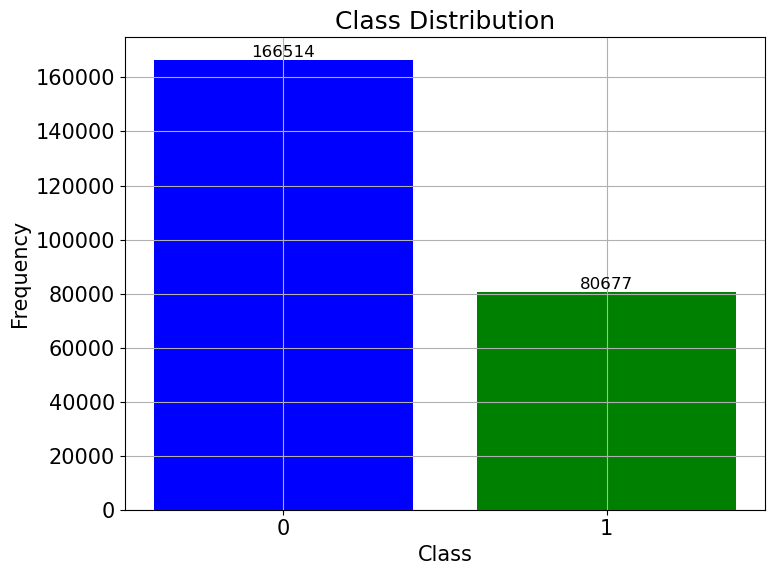

In [31]:
def plot_class_distribution(df, class_column):

    class_counts = df[class_column].value_counts()
    
    plt.figure(figsize=(8, 6))
    plt.bar(class_counts.index, class_counts.values, color=['blue', 'green'])
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(class_counts.index)
    
    for i, count in enumerate(class_counts.values):
        plt.text(class_counts.index[i], count, str(count), ha='center', va='bottom', fontsize=12)

    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_class_distribution(df_all, 'class')

In [33]:
df_slugging = df_all[df_all['class']== 1].copy()
df_normal = df_all[df_all['class']== 0].copy()

In [47]:
def plot_time_series(df, columns, start_time, end_time, resample_interval='5H'):
    
    df_time_window = df.loc[start_time:end_time]
    
    df_time_window_mean = df_time_window.resample(resample_interval).mean()
    
    num_features = len(columns)
    
    fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, 3 * num_features), sharex=True)
    
    for i, column in enumerate(columns):
        axes[i].plot(df_time_window_mean.index, df_time_window_mean[column], label=f'{column}', color='grey', alpha=0.8)
        
        axes[i].set_ylabel(column)
        axes[i].legend()
        axes[i].grid(True)
        
        if i == num_features - 1:
            axes[i].set_xticks([df_time_window_mean.index[0], df_time_window_mean.index[-1]])  
            axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  
            plt.xticks(rotation=45)
    
    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()


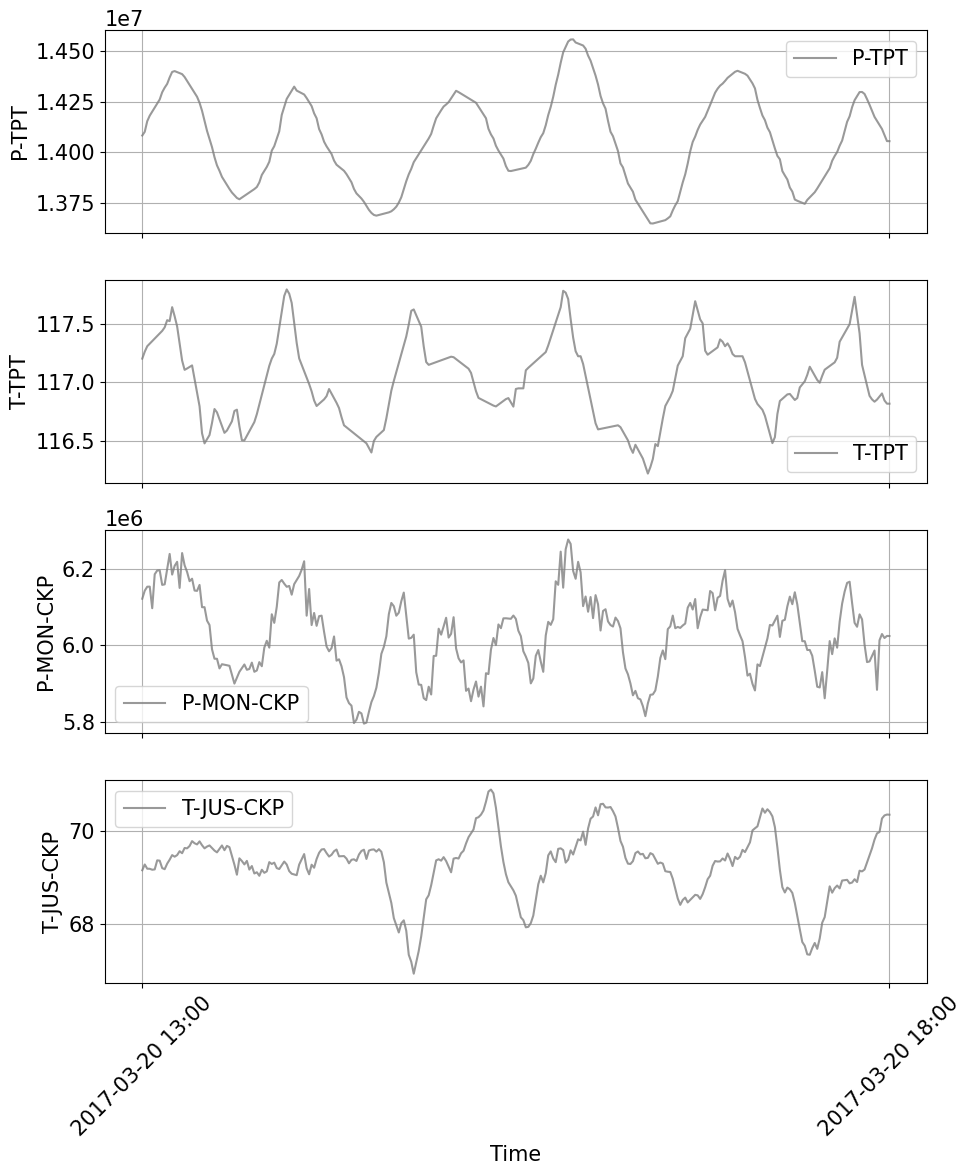

In [48]:
start_time = '2017-03-20 13:00:00'
end_time = '2017-03-20 18:00:00'

features = ['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']
plot_time_series(df_slugging, features, start_time, end_time, resample_interval='1T')


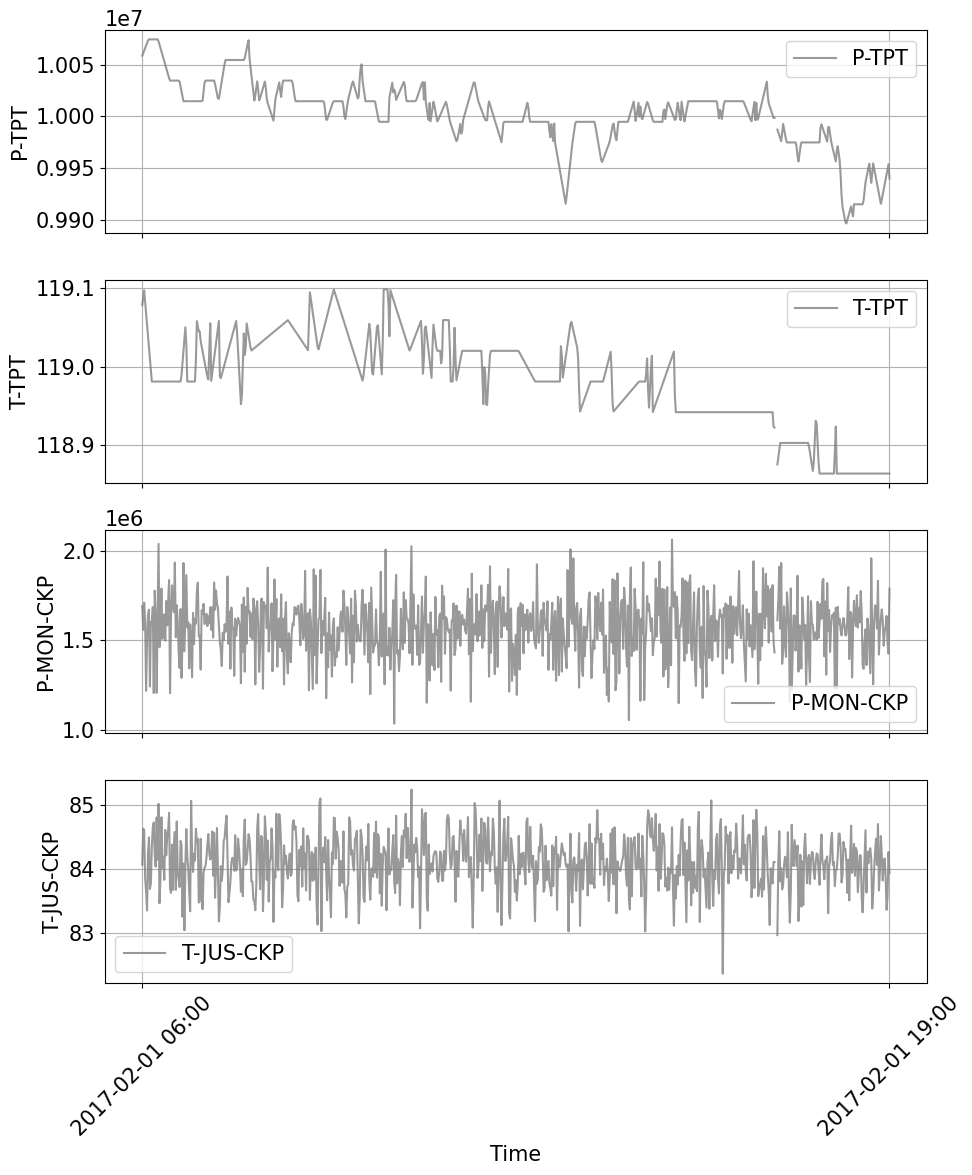

In [49]:
start_time = '2017-02-01 06:00:00'
end_time = '2017-02-01 19:00:00'
plot_time_series(df_normal, features, start_time, end_time, resample_interval='1T')

In [141]:
# Splitting the data into slugging and normal classes
df_slugging = df_all[df_all['class']== 1].copy()
df_normal = df_all[df_all['class']== 0].copy()


# Selecting instance (csv file)
# odd 0-700
sluggig_instance = 5
df_slugging_inst = df_slugging[df_slugging['id'] == sluggig_instance]


# even 2-702
normal_instance = 4
df_normal_inst = df_normal[df_normal['id'] == normal_instance]

In [93]:
# statistic_features = [
#         'mean', 
#         'std', 
#         'min', 
#         'median', 
#         'max',
#     ]

# window = 30

# winf_inp = WindowFeatures(
#     variables=["P-PDG", "P-TPT", "T-TPT", "P-MON-CKP", "T-JUS-CKP"],
#     window=window,
#     min_periods=window,
#     functions=statistic_features,
#     missing_values="ignore",
#     drop_original=False
# )

# df_slugging_inst = winf_inp.fit_transform(df_slugging_inst)
# df_normal_inst = winf_inp.fit_transform(df_normal_inst)

In [175]:
def FFT(df_instance, column):
    start_t = df_instance.index.min()
    end_t = df_instance.index.max()
    time_series = df_instance[f'{column}']

    fft_data = np.fft.fft(time_series)

    frequencies = np.fft.fftfreq(len(time_series), (end_t - start_t).total_seconds() / 60)
    return frequencies, fft_data

def smooth_fft(frequencies, fft_data, window_size=20):

    real = np.real(fft_data)
    imaginary = np.imag(fft_data)
    df_fft = pd.DataFrame({'frequency': frequencies, 'real': real, 'imaginary': imaginary})
    
    # Apply a rolling mean to smooth the imaginary part
    df_fft['smoothed_real'] = df_fft['real'].rolling(window=window_size, center=True).mean()
    df_fft['smoothed_imaginary'] = df_fft['imaginary'].rolling(window=window_size, center=True).mean()
    df_fft.dropna(inplace=True)
    
    return df_fft

In [171]:
frequencies, fft_data = FFT(df_slugging_inst, 'P-TPT')
df_fft = smooth_fft(frequencies, fft_data, window_size=20)
df_fft

,frequency,real,imaginary,smoothed_real,smoothed_imaginary
19,0.000018,5.110725e+07,-8.045426e+07,5.445547e+08,-1.505571e+07
20,0.000019,-5.966899e+07,3.279392e+06,1.149219e+07,-1.933896e+07
21,0.000020,8.372657e+07,-6.221656e+07,1.453970e+07,-1.350534e+07
22,0.000021,-4.730029e+07,-5.939057e+07,1.209038e+07,-1.147034e+07
23,0.000022,-5.653392e+07,5.854420e+07,1.008269e+07,-1.627997e+07
...,...,...,...,...,...
1020,-0.000013,6.211964e+07,-2.201348e+07,3.313455e+06,5.824572e+06
1021,-0.000012,1.186577e+08,-1.001198e+08,1.022306e+07,4.012500e+06
1022,-0.000011,2.813281e+07,-1.575875e+08,1.248738e+07,5.002821e+06
1023,-0.000010,-1.500481e+08,2.081103e+07,6.785835e+06,4.379393e+05


In [177]:
df_fft['magnitude'] = np.sqrt(df_fft['real']**2 + df_fft['imaginary']**2)
df_fft['smoothed_magnitude'] = np.sqrt(df_fft['smoothed_real']**2 + df_fft['smoothed_imaginary']**2)


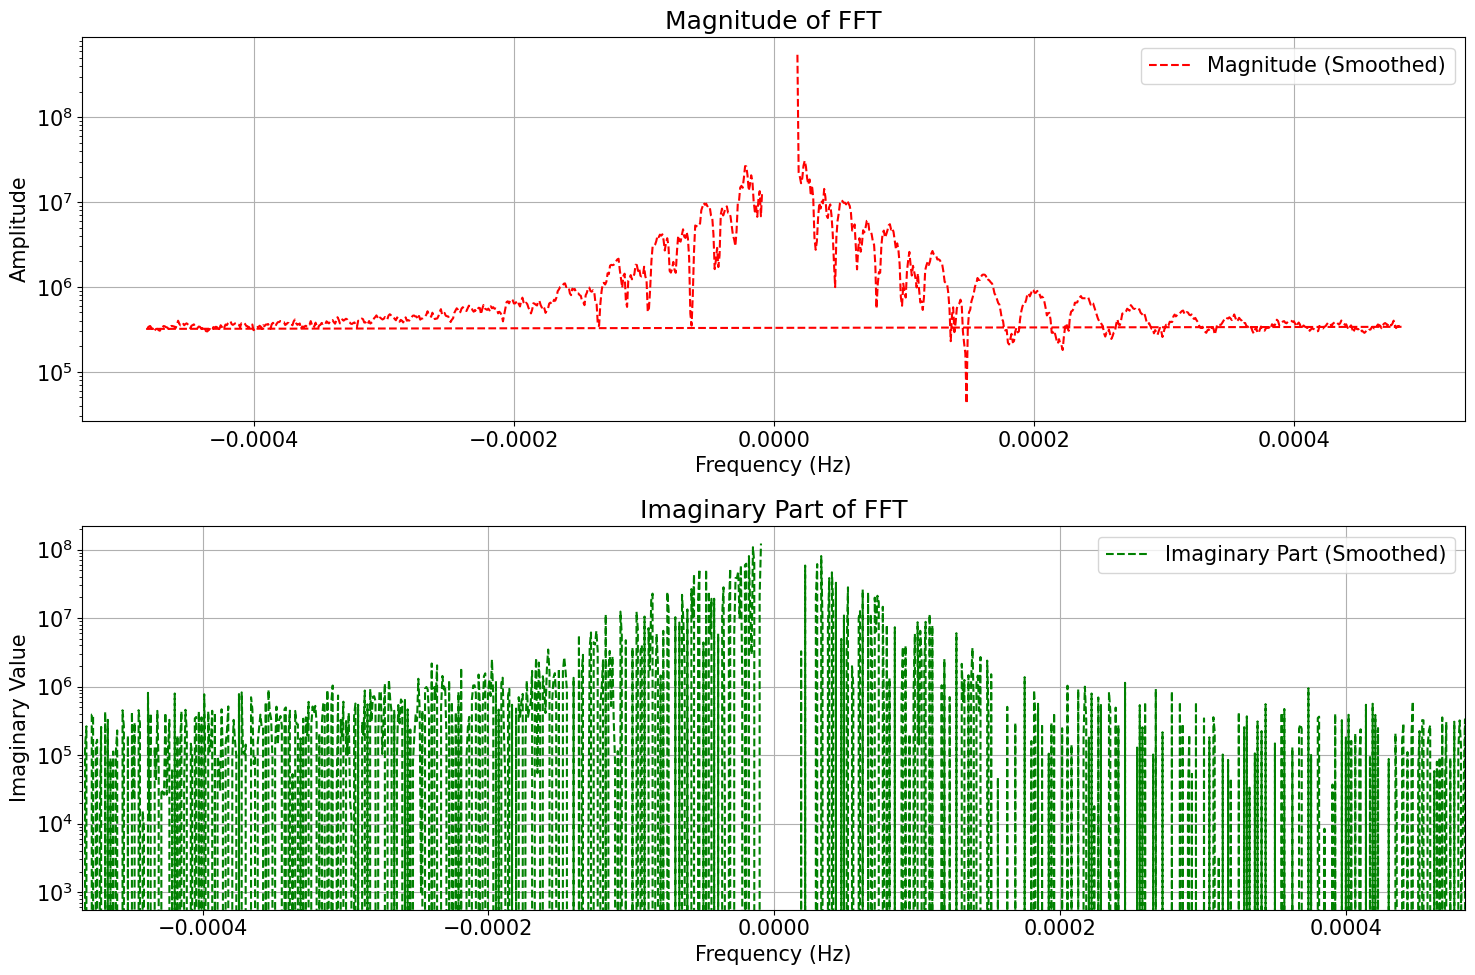

In [178]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(df_fft['frequency'], df_fft['smoothed_magnitude'], label='Magnitude (Smoothed)', linestyle='--', color='red')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Magnitude of FFT')
plt.yscale('log')
plt.grid(True)
plt.legend()

# Plot the imaginary part (original and smoothed)
plt.subplot(2, 1, 2)
plt.plot(df_fft['frequency'], df_fft['imaginary'], label='Imaginary Part (Smoothed)', linestyle='--', color='green')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Imaginary Value')
plt.title('Imaginary Part of FFT')
plt.xlim([df_fft['frequency'].min(), df_fft['frequency'].max()])
plt.yscale('log')
plt.grid(True)
plt.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [119]:
# Plot the magnitude and imaginary part
plt.figure(figsize=(15, 10))

# Plot the magnitude (absolute value)
plt.subplot(2, 1, 1)
plt.plot(frequencies, fft_data_abs, label='Magnitude (Absolute Value)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title(f'Magnitude of FFT')
plt.yscale('log')
plt.grid(True)

# Plot the imaginary part
plt.subplot(2, 1, 2)
plt.plot(frequencies, fft_data_i, label='Imaginary Part', color='orange')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Imaginary Value')
plt.title(f'Imaginary Part of FFT')
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()

ValueError: not enough values to unpack (expected 3, got 2)

/home/marcos/miniconda3/envs/vfm_3wdataset/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


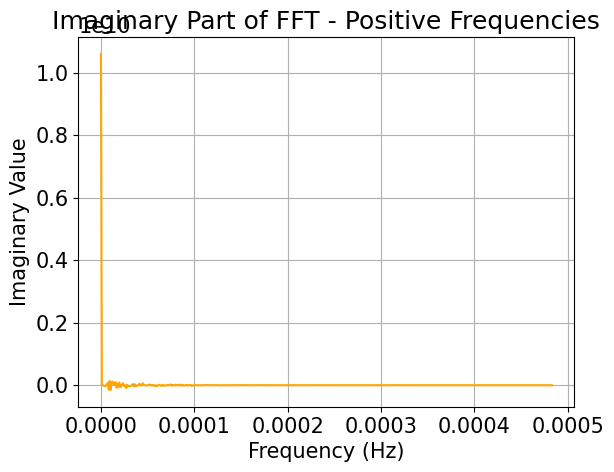

In [108]:
positive_freqs = frequencies[frequencies >= 0]
positive_imag_part = fft_data_i[frequencies >= 0]

# Plot only the positive frequencies
plt.plot(positive_freqs, positive_imag_part, label='Imaginary Part', color='orange')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Imaginary Value')
plt.title('Imaginary Part of FFT - Positive Frequencies')
plt.yscale('log')
plt.grid(True)
plt.show()

/home/marcos/miniconda3/envs/vfm_3wdataset/lib/python3.9/site-packages/pandas/core/window/rolling.py:404: ComplexWarning: Casting complex values to real discards the imaginary part
  values = ensure_float64(values)


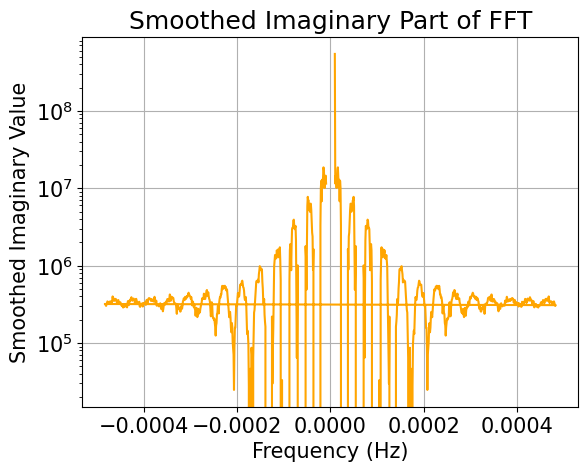

In [140]:
# Convert to DataFrame for rolling mean
df_fft = pd.DataFrame({'frequency': frequencies, 'imag_part': fft_data_i})

# Apply a rolling mean to smooth the data
df_fft['smoothed_imag'] = df_fft['imag_part'].rolling(window=20, center=True).mean()

# Plot the smoothed imaginary part
plt.plot(df_fft['frequency'], df_fft['smoothed_imag'], label='Smoothed Imaginary Part', color='orange')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Smoothed Imaginary Value')
plt.title('Smoothed Imaginary Part of FFT')
plt.yscale('log')
plt.grid(True)
plt.show()

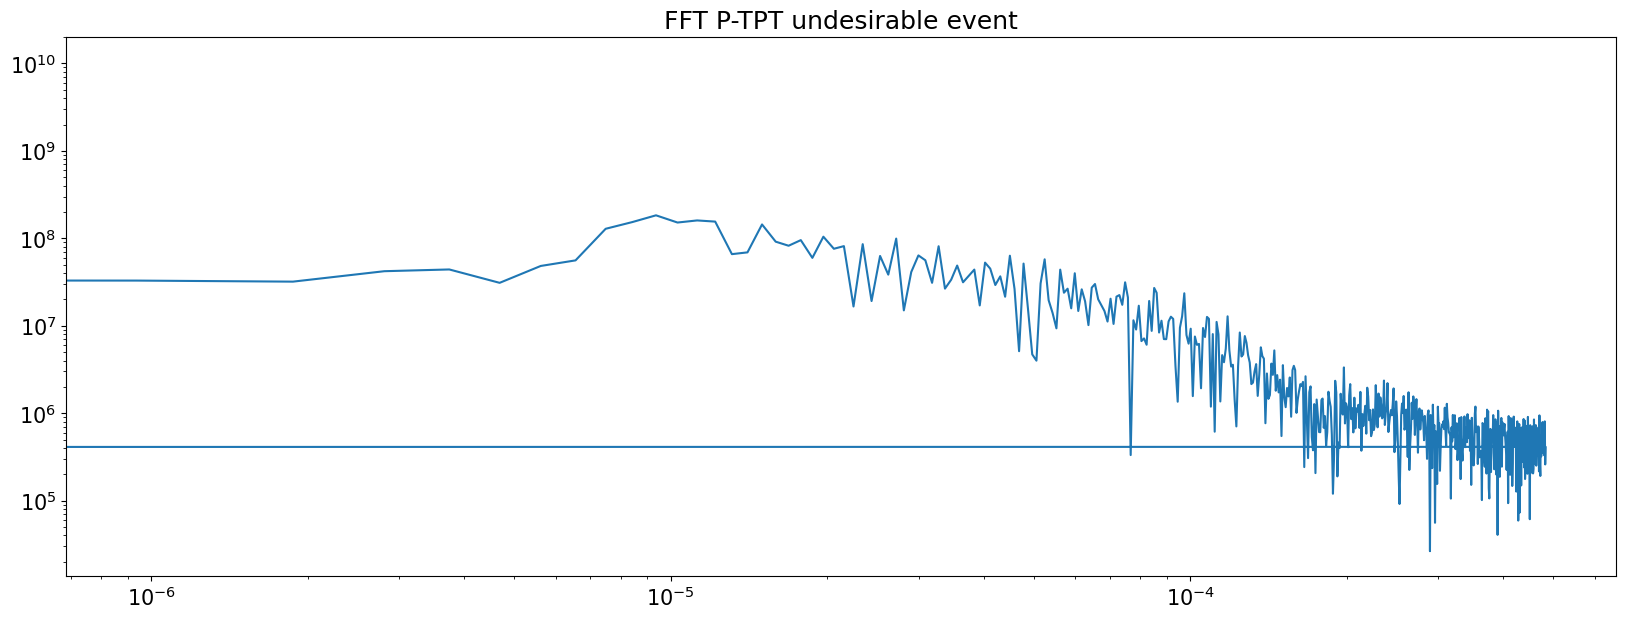

In [66]:

df_inst = df_train[df_train['id'] == inst]
s_t = df_inst.index.min()
e_t = df_inst.index.max()
column = 'P-TPT'
time_series = df_inst[f'{column}']
fft_data = np.abs(np.fft.fft(time_series))
frequencies = np.fft.fftfreq(len(time_series), (e_t - s_t).total_seconds()/60)

plt.figure(figsize=(20, 7))
plt.plot(frequencies, np.abs(fft_data), label=column)
plt.yscale('log')
plt.xscale('log')

if normal: 
    text = f'FFT {column} normal'
else: 
    text = f'FFT {column} undesirable event'

plt.title(text)

mean = np.mean(fft_data)
std = np.std(fft_data)
max = np.max(fft_data)
min = np.min(fft_data)

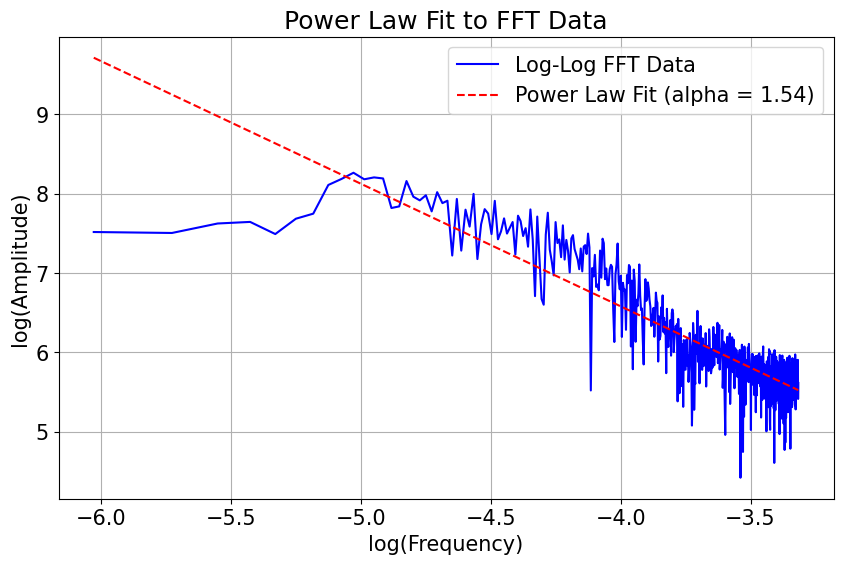

Power Law Exponent (alpha): 1.5431
Intercept: 0.4083


In [67]:
positive_freqs = frequencies[frequencies > 0]
positive_fft_data = fft_data[frequencies > 0]

log_freqs = np.log10(positive_freqs)
log_amplitudes = np.log10(np.abs(positive_fft_data))

slope, intercept, r_value, p_value, std_err = stats.linregress(log_freqs, log_amplitudes)

alpha = -slope

plt.figure(figsize=(10, 6))
plt.plot(log_freqs, log_amplitudes, 'b-', label='Log-Log FFT Data')
plt.plot(log_freqs, slope*log_freqs + intercept, 'r--', label=f'Power Law Fit (alpha = {alpha:.2f})')

plt.xlabel('log(Frequency)')
plt.ylabel('log(Amplitude)')
plt.title('Power Law Fit to FFT Data')
plt.legend()
plt.grid(True)
plt.show()

print(f'Power Law Exponent (alpha): {alpha:.4f}')
print(f'Intercept: {intercept:.4f}')

A power law with an exponent close to 1 is typical of systems where long-range correlations exist, meaning events or values that occur far apart in time are still statistically related.


# 